### DESEQ2 analysis of Hydrogel dataset

2 Factor design: 

* Stiffness (Soft v Stiff) 
* Saha (yes, no) 

* 221511 naive overlap peaks 
* 3 biological replicates per Sample 

In [70]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")
library(sva)
library(limma)

## Load data and design

In [71]:
#load ATAC-seq raw read counts
data=read.table('hydrogel.soft.stiff.saha.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL

data=data[rowSums(data)>0,]


In [72]:
head(data)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3,saha_100Pa_Rep1,saha_100Pa_Rep2,saha_100Pa_Rep3,saha_2000Pa_Rep1,saha_2000Pa_Rep2,saha_2000Pa_Rep3
chr1_713708_714452,6,11,7,17,27,17,25,23,16,22,24,20
chr1_762643_763047,1,5,0,3,7,4,5,5,2,3,6,7
chr1_802987_803295,2,7,4,3,3,1,8,6,6,7,8,4
chr1_804984_805589,2,6,1,6,7,6,7,3,4,5,16,4
chr1_834765_835239,7,12,14,15,7,9,5,2,0,8,10,4
chr1_839144_839717,13,17,5,23,15,20,6,4,3,5,12,11


In [73]:
#load the metadata
batches=read.table("batches_hydrogel.soft.stiff.saha.txt",header=TRUE,sep='\t',row.names=1)
batches$Stiffness=factor(batches$Stiffness)
batches$Saha=factor(batches$Saha)
batches$Sample=factor(batches$Sample)


In [74]:
batches

,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
X2000Pa_3D_Rep1,Stiff,No,2000Pa
X2000Pa_3D_Rep2,Stiff,No,2000Pa
X2000Pa_3D_Rep3,Stiff,No,2000Pa
saha_100Pa_Rep1,Soft,Yes,saha_100Pa
saha_100Pa_Rep2,Soft,Yes,saha_100Pa
saha_100Pa_Rep3,Soft,Yes,saha_100Pa
saha_2000Pa_Rep1,Stiff,Yes,saha_2000Pa


## Soft vs Stiff Analysis 


In [75]:
soft_stiff_data=data[,1:12]
soft_stiff_batches=batches[1:12,]

In [76]:
head(soft_stiff_data)
soft_stiff_batches

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3,saha_100Pa_Rep1,saha_100Pa_Rep2,saha_100Pa_Rep3,saha_2000Pa_Rep1,saha_2000Pa_Rep2,saha_2000Pa_Rep3
chr1_713708_714452,6,11,7,17,27,17,25,23,16,22,24,20
chr1_762643_763047,1,5,0,3,7,4,5,5,2,3,6,7
chr1_802987_803295,2,7,4,3,3,1,8,6,6,7,8,4
chr1_804984_805589,2,6,1,6,7,6,7,3,4,5,16,4
chr1_834765_835239,7,12,14,15,7,9,5,2,0,8,10,4
chr1_839144_839717,13,17,5,23,15,20,6,4,3,5,12,11


,Stiffness,Saha,Sample
X100Pa_3D_Rep1,Soft,No,100Pa
X100Pa_3D_Rep2,Soft,No,100Pa
X100Pa_3D_Rep3,Soft,No,100Pa
X2000Pa_3D_Rep1,Stiff,No,2000Pa
X2000Pa_3D_Rep2,Stiff,No,2000Pa
X2000Pa_3D_Rep3,Stiff,No,2000Pa
saha_100Pa_Rep1,Soft,Yes,saha_100Pa
saha_100Pa_Rep2,Soft,Yes,saha_100Pa
saha_100Pa_Rep3,Soft,Yes,saha_100Pa
saha_2000Pa_Rep1,Stiff,Yes,saha_2000Pa


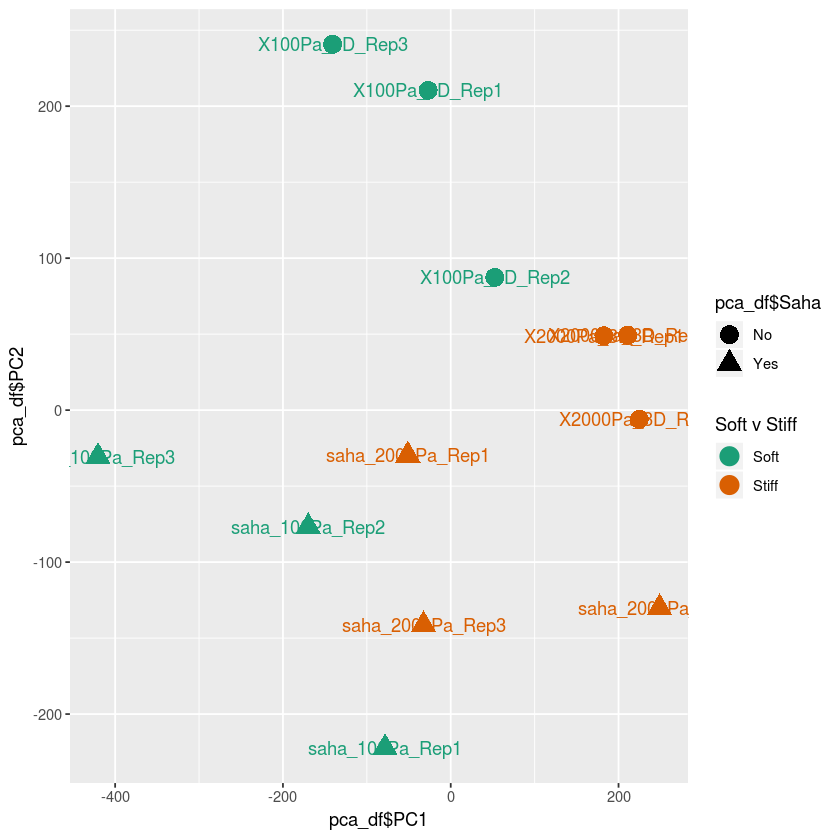

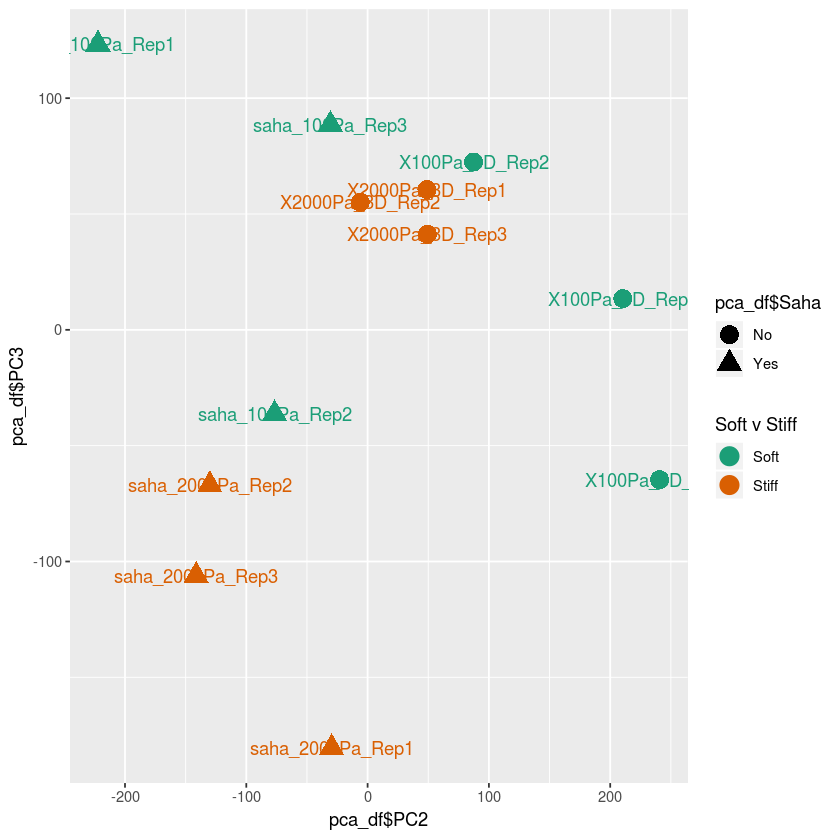

In [77]:
#PCA on shifted log of normalized counts
normcounts=soft_stiff_data
normcounts[normcounts<0]=0
lognc=log2(normcounts+1)
data.pca=prcomp(t(lognc))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)

pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            label=rownames(pca_df),
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p1

p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            label=rownames(pca_df),
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
geom_text()+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p2

In [11]:
#Surrogate Variable Analysis 
soft_stiff_data=soft_stiff_data[rowSums(soft_stiff_data)>0,]
mod0=model.matrix(~1,data=soft_stiff_batches)
mod1=model.matrix(~Stiffness,data=soft_stiff_batches)
sva.obj=svaseq(as.matrix(soft_stiff_data),mod1,mod0)


Number of significant surrogate variables is:  2 
Iteration (out of 5 ):1  2  3  4  5  

In [12]:
sur_var=data.frame(sva.obj$sv)
names(sur_var)=c("sv1","sv2")
soft_stiff_batches=cbind(soft_stiff_batches,sur_var)

In [37]:

#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = soft_stiff_data,
                              colData = soft_stiff_batches,
                              design = ~Stiffness)#+sv1+sv2)


In [38]:
#perform size factor estimation for for housekeeping (HK) promoters
hk_promoters=read.table("background/hydrogel.soft.stiff.saha.HK.txt",header=FALSE,sep='\t')
hk_promoters=paste(hk_promoters[,1],hk_promoters[,2],hk_promoters[,3],sep="_")
soft_stiff_hk_promoters=hk_promoters[,1:6]
soft_stiff_hk_promoter_indices=match(soft_stiff_hk_promoters,rownames(soft_stiff_data))
head(soft_stiff_hk_promoter_indices)

[1] 15 63 70 71 71 78

In [39]:
dds <- estimateSizeFactors(dds, controlGenes=soft_stiff_hk_promoter_indices)

## Extract and store normalized counts for further analysis 

In [40]:
normcounts=counts(dds,normalized=TRUE)

#use limma's removeBatchEffect function 
tokeep=model.matrix(~Stiffness,data=soft_stiff_batches)
normcounts=removeBatchEffect(normcounts,design=tokeep,covariates = subset(soft_stiff_batches,select=c("sv1","sv2")))


write.table(normcounts,"soft_stiff_normcounts_from_deseq.txt",quote=FALSE,sep='\t',col.names=TRUE,row.names=TRUE)


In [41]:
head(normcounts)

,X100Pa_3D_Rep1,X100Pa_3D_Rep2,X100Pa_3D_Rep3,X2000Pa_3D_Rep1,X2000Pa_3D_Rep2,X2000Pa_3D_Rep3
chr1_713708_714452,10.389286,8.994839,10.072496,14.223168,18.900482,13.768883
chr1_762643_763047,2.166286,1.837060,2.091492,2.829489,4.345750,3.546150
chr1_802987_803295,5.151955,5.205100,5.164028,2.702348,1.678516,1.028523
chr1_804984_805589,3.249119,3.428959,3.289975,5.216856,4.504169,5.056520
chr1_834765_835239,13.724373,14.860052,13.982376,12.058272,5.473034,6.876461
chr1_839144_839717,13.166284,15.031777,13.590085,18.932519,10.868778,15.927412


## Differential Accessibility Operation

In [42]:
#Run the differential analysis
dds <- DESeq(dds,parallel = TRUE)


using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates: 20 workers
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates, fitting model and testing: 20 workers


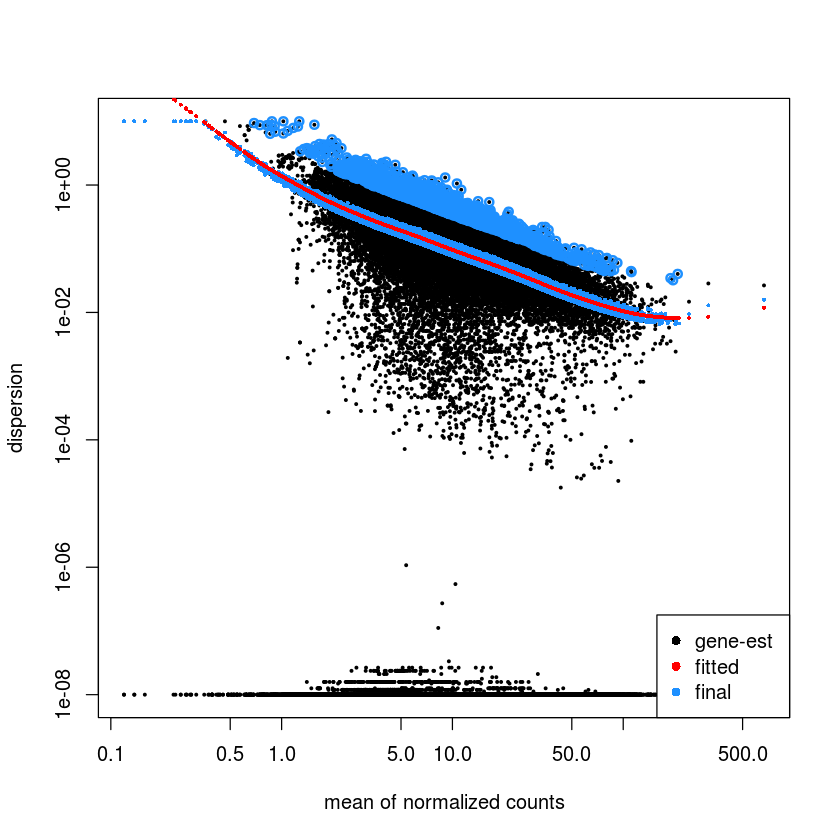

In [43]:
plotDispEsts(dds)

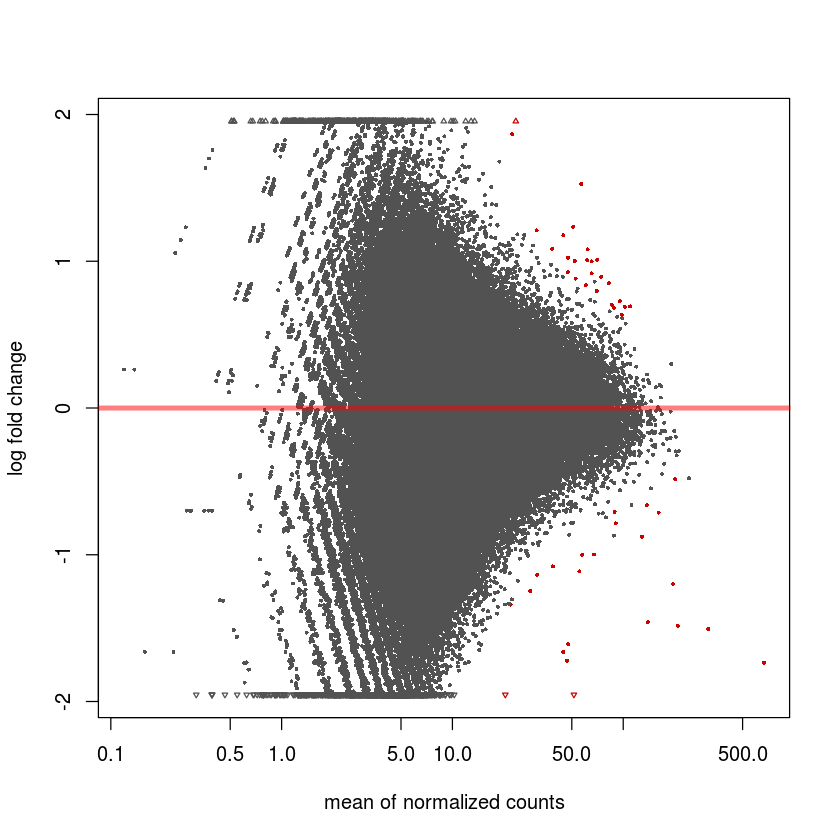

In [44]:
DESeq2::plotMA(dds)

## Standard BH Correction (no optimal thresholding) 

In [45]:
res=results(dds)
summary(res)

res=results(dds,independentFiltering=FALSE)
summary(res)

res=results(dds,filterFun = ihw)
summary(res)


out of 221485 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 26, 0.012%
LFC < 0 (down)     : 23, 0.01%
outliers [1]       : 0, 0%
low counts [2]     : 193234, 87%
(mean count < 20)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221485 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 14, 0.0063%
LFC < 0 (down)     : 19, 0.0086%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results


out of 221485 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 30, 0.014%
LFC < 0 (down)     : 25, 0.011%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [46]:
resultsNames(dds)

[1] "Intercept"               "Stiffness_Stiff_vs_Soft"

In [47]:
res=results(dds,name="Stiffness_Stiff_vs_Soft",parallel=TRUE)

[1] 37


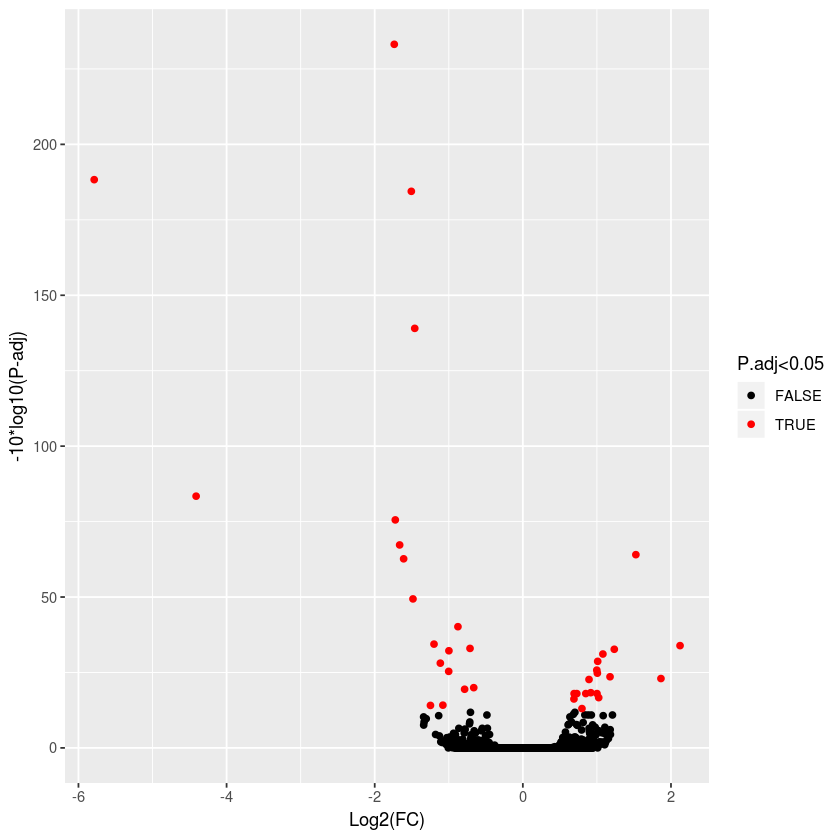

In [48]:
        res$logPadj=-10*log10(res$padj)
        res=as.data.frame(res)
        res=na.omit(res)
        numsig=sum(res$padj <= 0.05)
        sigsubset=res[res$padj<=0.05,]
        res$color=res$padj<=0.05
        ggplot(data=res,
        aes(x=res$log2FoldChange,
                 y=res$logPadj,
                 color=res$color))+
                 geom_point()+
                 xlab("Log2(FC)")+
                 ylab("-10*log10(P-adj)")+
                 scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05")
print(numsig)

## Visualizations 

In [50]:
#PCA on shifted log of normalized counts
normcounts[normcounts<0]=0
lognc=log2(normcounts+1)
data.pca=prcomp(t(lognc))
var_explained=round(100*data.pca$sdev^2/sum(data.pca$sdev^2),2)
var_explained_df=data.frame(seq(1,length(var_explained)),var_explained)



In [51]:
var_explained_df

seq.1..length.var_explained..,var_explained
1,50.16
2,26.12
3,23.53
4,0.18
5,0.00
6,0.00


In [52]:
pca_df=data.frame(data.pca$x)
pca_df=cbind(pca_df,soft_stiff_batches)


In [55]:
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,Stiffness,Saha,Sample,sv1,sv2
X100Pa_3D_Rep1,-125.76357,2.20916467,-6.185159,9.584429,0.6488172078,9.696966e-13,Soft,No,100Pa,-0.74406473,-0.3109971
X100Pa_3D_Rep2,-108.29818,-7.29052969,52.658244,-13.807999,0.1885941105,1.119596e-12,Soft,No,100Pa,0.07473845,0.7916671
X100Pa_3D_Rep3,-121.73081,0.05361571,7.189833,4.317790,-0.8376110167,1.570563e-12,Soft,No,100Pa,0.65909566,-0.4694272
X2000Pa_3D_Rep1,141.36354,-161.17599250,38.805762,1.569841,0.0002828286,-4.733787e-13,Stiff,No,2000Pa,-0.02909586,-0.1004775
X2000Pa_3D_Rep2,67.32762,27.19672826,-174.452085,-3.239990,-0.0003904549,-5.837083e-13,Stiff,No,2000Pa,0.06842234,0.1897122
X2000Pa_3D_Rep3,147.10140,139.00701355,81.983404,1.575929,0.0003073247,-2.560175e-12,Stiff,No,2000Pa,-0.02909586,-0.1004775


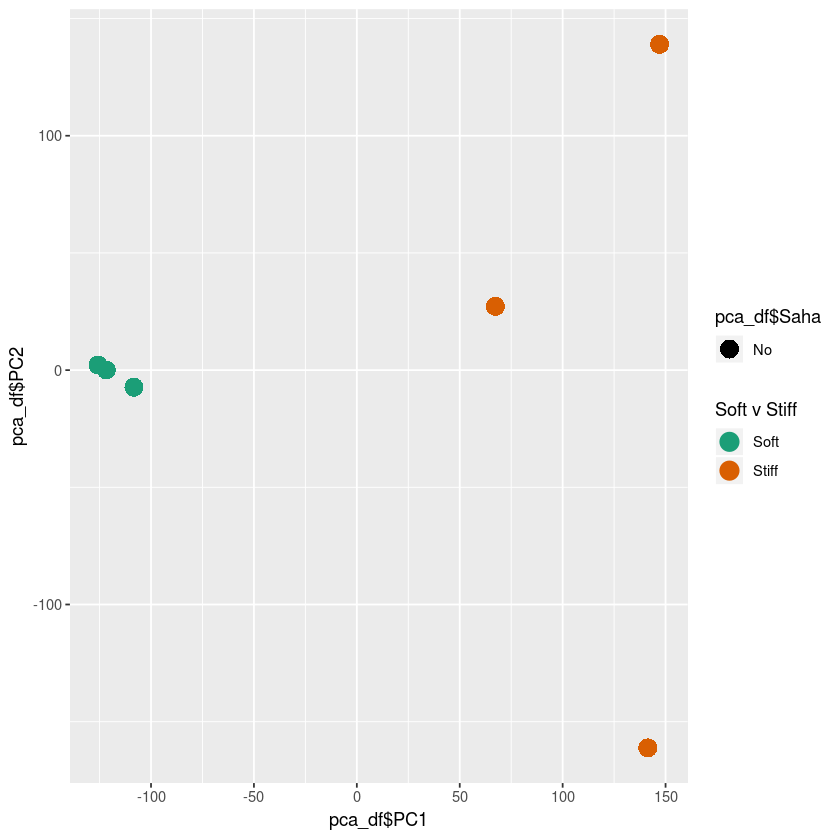

In [53]:
p1=ggplot(data=pca_df,
         aes(x=pca_df$PC1,
            y=pca_df$PC2,
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p1

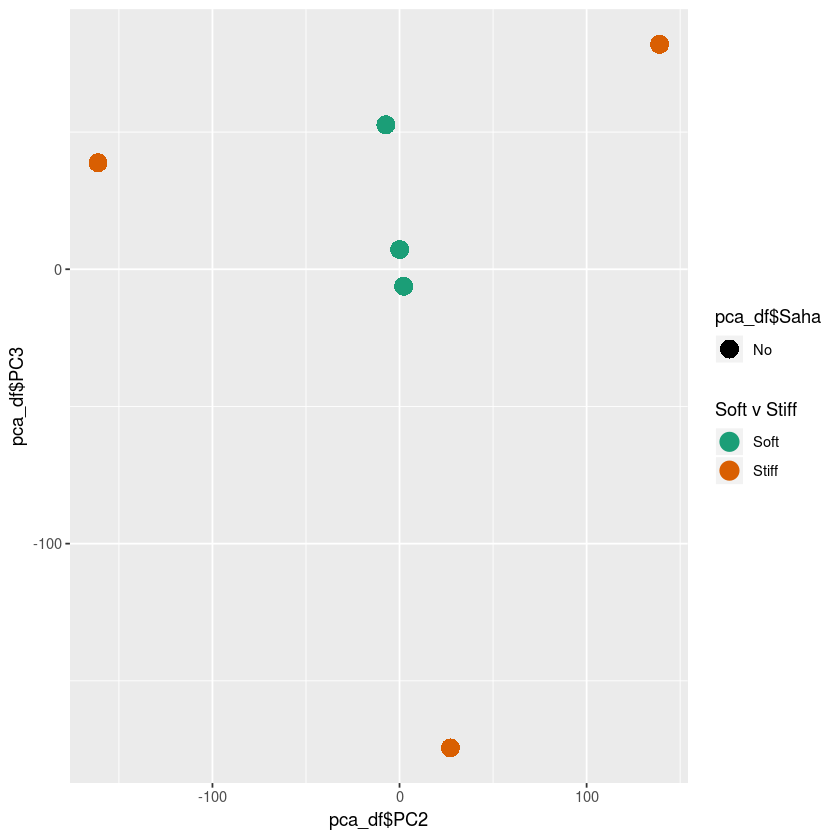

In [54]:
p2=ggplot(data=pca_df,
         aes(x=pca_df$PC2,
            y=pca_df$PC3,
            color=pca_df$Stiffness,
            shape=pca_df$Saha))+
geom_point(size=5)+
scale_color_manual(name='Soft v Stiff',values=c("#1b9e77","#d95f02"))
p2

In [ ]:
## Perform transformations 
#vsd=vst(dds,blind=FALSE)
#rld=rlog(dds,blind=FALSE)
ntd <- normTransform(normcounts)



In [ ]:
## Heatmap on Transformed Data 

select <- order(rowMeans(counts(dds,normalized=TRUE)),
                decreasing=TRUE)


df <- as.data.frame(colData(dds)[,c("Treatment","CellCycle")])

#log2(n + 1)
pheatmap(assay(ntd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

#VST Transform 
pheatmap(assay(vsd)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

#Rlog Transform 
pheatmap(assay(rld)[select,], cluster_rows=FALSE, show_rownames=FALSE,
         cluster_cols=FALSE, annotation_col=df)

## Find an Optimal Filtering Threshold with -log10Pval v baseMean

In [25]:
res=results(dds)
res$filtRatio=-log10(res$pvalue)/res$baseMean
res_df=as.data.frame(res[order(-res$filtRatio),])

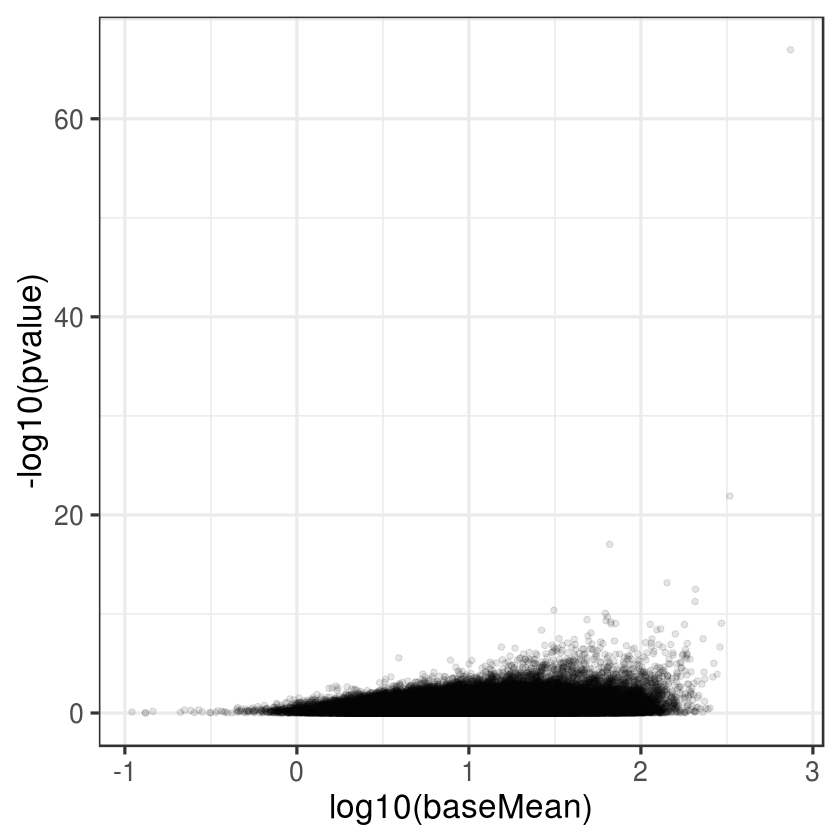

In [26]:
ggplot(data=res_df,
       aes(x=log10(res_df$baseMean),
           y=-log10(res_df$pvalue)))+
       geom_point(alpha=0.1)+
       xlab("log10(baseMean)")+
       ylab("-log10(pvalue)")+
       theme_bw(20)
       
       


## Find an optimal filtering threshold with IHW

In [27]:
library("IHW")
resIHW=results(dds,filterFun=ihw)
summary(resIHW)


out of 221490 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 1035, 0.47%
LFC < 0 (down)     : 679, 0.31%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [28]:
sum(resIHW$padj < 0.1, na.rm=TRUE)



[1] 1714

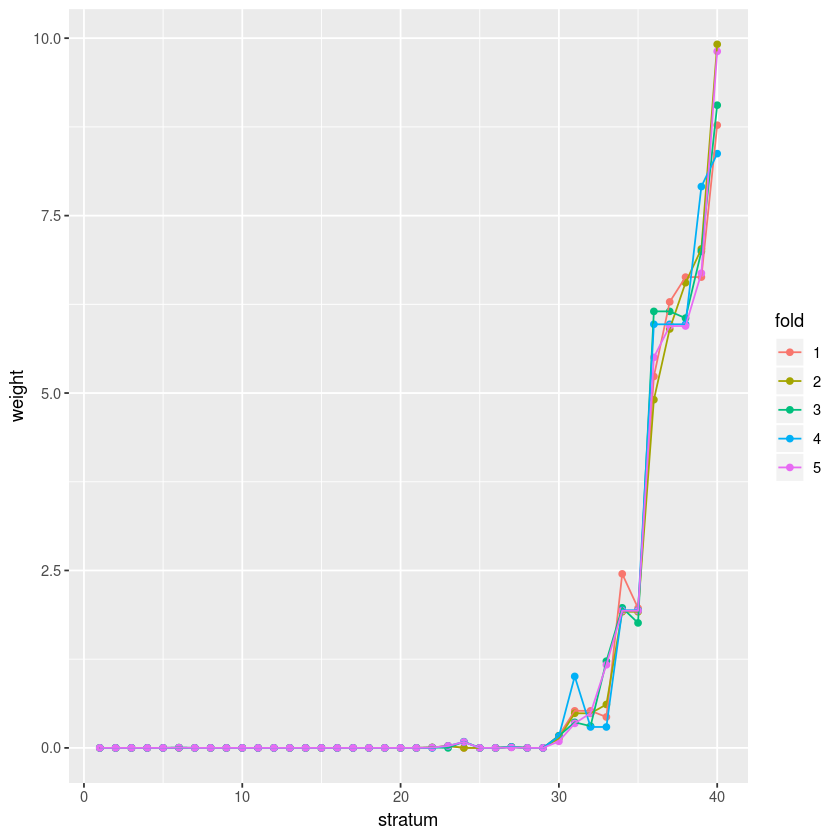

In [29]:
plot(metadata(resIHW)$ihwResult)



## Independent Filtering 

In [30]:
metadata(res)$alpha


[1] 0.1

In [31]:
metadata(res)$filterThreshold


81.42857% 
 15.73572

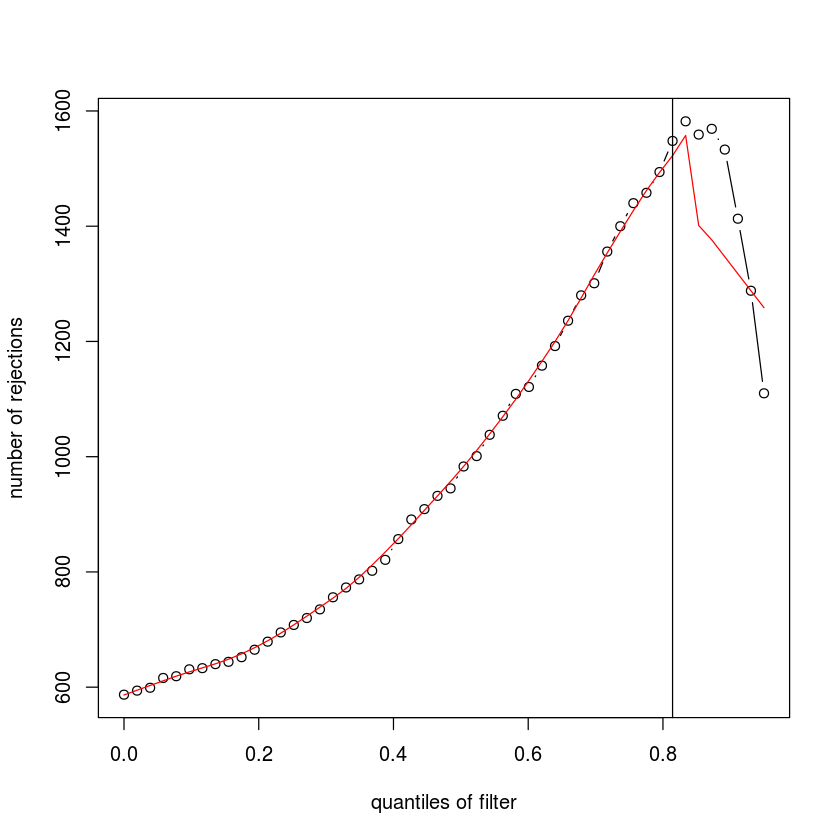

In [32]:
plot(metadata(res)$filterNumRej, 
     type="b", ylab="number of rejections",
     xlab="quantiles of filter")
lines(metadata(res)$lo.fit, col="red")
abline(v=metadata(res)$filterTheta)

In [33]:
resNoFilt <- results(dds, independentFiltering=FALSE)
addmargins(table(filtering=(res$padj < .1),
                 noFiltering=(resNoFilt$padj < .1)))

,FALSE,TRUE,Sum
FALSE,39586,0,39586
TRUE,1024,524,1548
Sum,40610,524,41134


In [34]:
summary(resNoFilt)


out of 221490 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 393, 0.18%
LFC < 0 (down)     : 194, 0.088%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results

